In [113]:
import json
import os
import csv

from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import cluster
from sklearn import manifold
from sklearn import preprocessing
from scipy.spatial.distance import cdist
import numpy as np
import math
import time
import re
import pandas as pd
from sklearn.neighbors.kde import KernelDensity

data = []
fileNames = []
fileSize = []
group_labels = []

###############################################
# Read Documents
###############################################

for root, dirs, files in os.walk("wiki-docs-large"):
    for filePath in files:
        if filePath.endswith(".txt"):
            with open(os.path.join(root, filePath), 'r') as file:
                file_content = file.read()
                data.append(file_content)
                fileNames.append(filePath)
                fileSize.append(len(file_content))
                group_labels.append(root)
                
group_encoder = preprocessing.LabelEncoder()
group_encoder.fit(group_labels)
group_labels = group_encoder.transform(group_labels)

[doc[:100] + '...' for doc in data]

['The 2010 United Nations Climate Change Conference was held in Cancn, Mexico, from 29 November to 10 ...',
 'The 2011 United Nations Climate Change Conference (COP17) was held in Durban, South Africa, from 28 ...',
 'An abrupt climate change occurs when the climate system is forced to transition to a new climate sta...',
 'In physics, absorption of electromagnetic radiation is the way in which the energy of a photon is ta...',
 'Attribution of recent climate change is the effort to scientifically ascertain mechanisms responsibl...',
 'Bangladesh ( ( listen) or ; Bengali:  Blda, pronounced [balade] ( listen), lit."The country of Benga...',
 'Sir Brian John Hoskins CBE FRS, (born 17 May 1945) is a British dynamical meteorologist and climatol...',
 'Not to be confused with- Calcification\nAuthorities differ on the meaning of calcination (also referr...',
 'Carbon dioxide removal (CDR) refers to a number of technologies, the objective of which is the large...',
 'A carbon tax is a tax lev

In [114]:
topics = [
    'talk.politics.guns', 
    'soc.religion.christian', 
    'comp.graphics', 
    'comp.windows.x', 
    'rec.sport.baseball', 
    'rec.sport.hockey', 
    'sci.space'
]

articles_per_topic = 200

data = []
fileNames = []
fileSize = []
group_labels = []

for topic_i, topic in enumerate(topics):
    for root, dirs, files in os.walk('20_newsgroup/{}'.format(topic)):
        for filePath in files[:articles_per_topic]:
            with open(os.path.join(root, filePath), 'r') as file:
                file_content = file.read()
                end_of_header = file_content.find('\n\n') + 2;
                article_content = file_content[end_of_header:]
                if len(article_content) > 1000:
                    data.append(article_content)
                    
                    subject_search = re.search('Subject: (.*)', file_content)
                    if subject_search:
                        fileNames.append(subject_search.group(1))
                    else:
                        fileNames.append(topic)
                    group_labels.append(topic_i)
                    fileSize.append(len(file_content))
                
[doc[:100] + '...' for doc in data]

['hambidge@bms.com wrote:\n: In article <C4psoG.C6@magpie.linknet.com>, manes@magpie.linknet.com (Steve...',
 'Jim De Arras (jmd@cube.handheld.com) wrote:\n: > Last year the US suffered almost 10,000 wrongful or ...',
 'Steve Kao (k@hprnd.rose.hp.com) wrote:\n: Frank Crary posted:\n: : Sure, but the difference in per-cap...',
 '\n----------------------------------------------------------------------\nOpen letter by Dr. Paul H. B...',
 '\nThe ATF agent interviewed on "Street Stories" reported that the raid was\nill planned, and went ahea...',
 'manes@magpie.linknet.com (Steve Manes) writes:\n\n>hambidge@bms.com wrote:\n>: In article <C4psoG.C6@ma...',
 'In article <C4tsD1.1vA@news.cso.uiuc.edu> irvine@uxh.cso.uiuc.edu (Brent Irvine) writes:\n>In article...',
 '>In article <1993Mar28.180629.21574@mnemosyne.cs.du.edu> rcanders@nyx.cs.du.edu (Mr. Nice Guy) write...',
 '-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-\n Announcing. . . Announcing. . . Annou...',
 '-+-+-+-+-+-+-

In [115]:
###############################################
# Vectorize Documents
###############################################

vectorizer = feature_extraction.text.TfidfVectorizer(stop_words='english', max_features=1000, smooth_idf=True, sublinear_tf=False, min_df=0.0, max_df=1.0, ngram_range=(1,1))
#Hashing seems to run into issues when there are 2 identical documents
#vectorizer = feature_extraction.text.HashingVectorizer(n_features=2**17, stop_words='english', alternate_sign=False, norm='l2', binary=False, ngram_range=(2,2))

# don't load everything into memory with https://stackoverflow.com/questions/16453855/tfidfvectorizer-for-corpus-that-cannot-fit-in-memory
doc_vectors = vectorizer.fit_transform(data).todense()

np.savetxt('doc_vectors.csv', doc_vectors, delimiter=",")
np.savetxt('group_labels.tsv', np.array([group_labels]), delimiter="\t", fmt='%i')

terms = np.array(vectorizer.get_feature_names())

# deviations = np.array(np.std(doc_vectors, axis=0))[0]
# top_deviation_indicies = np.argpartition(deviations, -100)[-100:]
# doc_vectors = doc_vectors[:, top_deviation_indicies]
# terms = terms[top_deviation_indicies]

df = pd.DataFrame(doc_vectors, columns=terms, index=fileNames)
df

,00,000,01,02,03,04,05,10,100,11,...,xlib,xm,xt,xterm,xvoid,year,years,yes,york,young
Re: Gun Control (was Re: We're Mad as Hell at the TV News),0.000000,0.403873,0.0,0.0,0.0,0.0,0.0,0.075433,0.187472,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.051838,0.000000
Re: Gun Control (was Re: We're Mad as Hell at the TV News),0.000000,0.075556,0.0,0.0,0.0,0.0,0.0,0.028224,0.035072,0.049757,...,0.0,0.0,0.0,0.0,0.0,0.075673,0.000000,0.000000,0.019396,0.000000
Re: Gun Control (was Re: We're Mad as Hell at the TV News),0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.050689,0.000000,0.000000,0.077953,0.000000
Vancouver/Seattle Study Critiques,0.009822,0.047828,0.0,0.0,0.0,0.0,0.0,0.014293,0.035522,0.008399,...,0.0,0.0,0.0,0.0,0.0,0.038321,0.020819,0.000000,0.039289,0.009615
Waco dates - are these coincidental?,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Re: Gun Control (was Re: We're Mad as Hell at the TV News),0.000000,0.331269,0.0,0.0,0.0,0.0,0.0,0.061872,0.153771,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.042519,0.000000
Re: Gun Nuts and Holly Silva,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Re: ATF suspects drug lab in compound,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"PUBLIC HEARINGS on Ballot Access, Vote Fraud and Other Issues",0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.015835,0.019677,0.018610,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"PUBLIC HEARINGS on Ballot Access, Vote Fraud and Other Issues",0.026068,0.000000,0.0,0.0,0.0,0.0,0.0,0.037934,0.011785,0.022291,...,0.0,0.0,0.0,0.0,0.0,0.008476,0.018418,0.000000,0.000000,0.012759


In [116]:
cluster_alg = cluster.AffinityPropagation(preference=-10, damping=0.7)

cluster_alg.fit(doc_vectors);

order_centroids = cluster_alg.cluster_centers_.argsort()[:, ::-1]
for i in range(len(np.unique(cluster_alg.labels_))):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()
    docs_in_cluster = np.array(fileNames)[cluster_alg.labels_ == i]
    np.random.shuffle(docs_in_cluster)
    for i in range(min(4, len(docs_in_cluster))):
        print('\t' + str(docs_in_cluster[i]))

Cluster 0: manes rate killed 000 handgun uk magpie linknet likely population
	Re: Gun Control (was Re: We're Mad as Hell at the TV News)
	Re: Big amateur rockets
	Re: Gun Control (was Re: We're Mad as Hell at the TV News)
	Re: Gun Control (was Re: We're Mad as Hell at the TV News)
Cluster 1: revolver semi police cops auto hit shots shooting better armed
	Re: A universal RIGHT to bear arms? NOT!
	Orbit data - help needed
	Re: Gun Lovers (was Re: My Gun is like my American Express Card)
	Re: My Gun is like my American Express Card
Cluster 2: guns gun problem control weapons criminals think rate kill situation
	Newspapers censoring gun advertisements
	Re: the usual
	Re: Orbital RepairStation
	Re: Gov't break-ins (Re: 60 minutes)
Cluster 3: faith god does christianity christ christian life bible heaven man
	re: Pantheism and Environmentalism
	Re: Revelations
	Atheist's views on Christianity (was: Re: "Accepting Jeesus in your heart...")
	"Accepting Jeesus in your heart..."
Cluster 4: god b

In [ ]:
colors = [20] * doc_vectors.shape[0]
colors[0] = 100;
plt.scatter(df['united'], df['climate'], c=colors, s=colors)
plt.show()

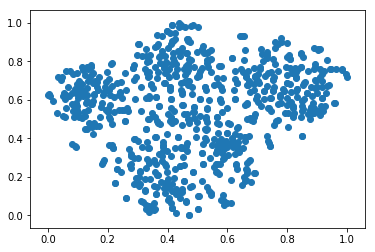

In [117]:
###############################################
# Reduce Dimensionality
###############################################
#https://distill.pub/2016/misread-tsne/

#dimension_reducer = decomposition.PCA(n_components=2)
#dimension_reducer = manifold.Isomap(10, eigen_solver='auto', n_components=2)
dimension_reducer = manifold.TSNE(perplexity=min(round(3 + doc_vectors.shape[0]/10), 50))
#dimension_reducer = decomposition.TruncatedSVD() # doesn't require dense matrix

doc_points = dimension_reducer.fit_transform(doc_vectors)

# dimension_reducer1 = decomposition.TruncatedSVD(n_components=100) # set tfidf features to 10000+
# dimension_reducer2 = manifold.TSNE(perplexity=min(round(3 + doc_vectors.shape[0]/10), 50))
# doc_vectors_reduced = dimension_reducer1.fit_transform(doc_vectors)
# doc_points = dimension_reducer2.fit_transform(doc_vectors_reduced)

doc_points = preprocessing.minmax_scale(doc_points)

plt.scatter(doc_points[:, 0], doc_points[:, 1])
plt.show()

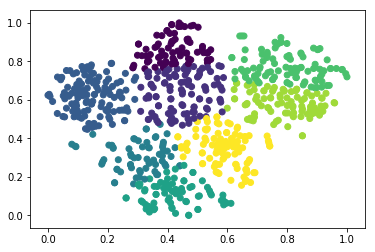

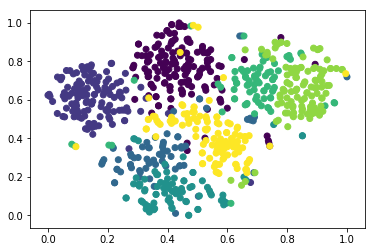

In [118]:
###############################################
# Assign Documents to Clusters
###############################################
#http://scikit-learn.org/stable/modules/clustering.html

def find_centers(points, point_labels):
    labels  = np.unique(point_labels)
    return {label: np.mean(points[point_labels==label], axis=0) for label in labels}

cluster_alg = cluster.AffinityPropagation(preference=-1.5, damping=0.7)

#cluster_alg = cluster.DBSCAN(eps=0.06, min_samples=round(doc_points.shape[0] / 40))

#cluster_alg = cluster.MeanShift(bin_seeding=True)

cluster_alg.fit(doc_points);

cluster_centers = find_centers(doc_points, cluster_alg.labels_)
#cluster_centers = cluster_alg.cluster_centers_

plt.scatter(doc_points[:, 0], doc_points[:, 1], c=cluster_alg.labels_);
plt.show()

plt.scatter(doc_points[:, 0], doc_points[:, 1], c=np.array(group_labels));
plt.show()

In [124]:
###############################################
# Additional Metrics
###############################################

distances_from_center = np.array([])

for i, doc in enumerate(doc_points):
    center = cluster_centers[cluster_alg.labels_[i]]
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(doc, center)]))
    distances_from_center = np.append(distances_from_center, distance)

if distances_from_center.max() > 0:
    distances_from_center = distances_from_center/distances_from_center.max()

file_size_as_features = np.array(fileSize).reshape(-2, 1)
rel_file_size = preprocessing.QuantileTransformer(output_distribution='uniform').fit_transform(file_size_as_features)[:,0]

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(doc_points)
density_at_doc = kde.score_samples(doc_points)
density_at_doc = preprocessing.MinMaxScaler().fit_transform(density_at_doc.reshape(-1, 1))[:,0]

###############################################
# Serialize
###############################################


docs = [{
    'x': float(doc[0]), 
    'y': float(doc[1]),
    'cluster': int(cluster_alg.labels_[i]),
    'name': fileNames[i], 
    'size': rel_file_size[i],
    'density': density_at_doc[i],
    'distanceFromCenter': distances_from_center[i],
    'group': int(group_labels[i])
} for i, doc in enumerate(doc_points)]

docs_as_lists = [[
    doc['name'], 
    doc['group'],
    doc['cluster']
] for doc in docs]

with open('docs.json', 'w') as json_file:
    json.dump(docs, json_file)
    
with open('docs.tsv', 'w') as tsv_file:
    wr = csv.writer(tsv_file, quoting=csv.QUOTE_ALL, delimiter='\t')
    wr.writerow(['Name', 'Group', 'Cluster'])
    wr.writerows(docs_as_lists)